In [ ]:
from google.colab import userdata
import os

In [ ]:
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [ ]:
!kaggle datasets download -d gunavenkatdoddi/eye-diseases-classification

Dataset URL: https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification
License(s): ODbL-1.0
100% 734M/736M [00:09<00:00, 98.9MB/s]
100% 736M/736M [00:09<00:00, 81.9MB/s]


In [ ]:
!unzip "/content/eye-diseases-classification.zip"

Archive:  /content/eye-diseases-classification.zip
  inflating: dataset/cataract/0_left.jpg  
  inflating: dataset/cataract/103_left.jpg  
  inflating: dataset/cataract/1062_right.jpg  
  inflating: dataset/cataract/1083_left.jpg  
  inflating: dataset/cataract/1084_right.jpg  
  inflating: dataset/cataract/1102_left.jpg  
  inflating: dataset/cataract/1102_right.jpg  
  inflating: dataset/cataract/1115_left.jpg  
  inflating: dataset/cataract/1126_right.jpg  
  inflating: dataset/cataract/112_right.jpg  
  inflating: dataset/cataract/1144_left.jpg  
  inflating: dataset/cataract/1144_right.jpg  
  inflating: dataset/cataract/1164_left.jpg  
  inflating: dataset/cataract/1167_right.jpg  
  inflating: dataset/cataract/119_left.jpg  
  inflating: dataset/cataract/1285_left.jpg  
  inflating: dataset/cataract/1415_left.jpg  
  inflating: dataset/cataract/1415_right.jpg  
  inflating: dataset/cataract/1435_left.jpg  
  inflating: dataset/cataract/1444_left.jpg  
  inflating: dataset/catara

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
import cv2
import glob
import albumentations as A
from pathlib import Path
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import InceptionResNetV2
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import layers,regularizers
from tensorflow.keras import callbacks

from tensorflow.keras.preprocessing.image import ImageDataGenerator

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.16 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
IMG_SIZE=224
BATCH_SIZE=32
EPOCHS=40
CHANNELS=3
N_CLASSES=4
INPUT_SHAPE = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS)

In [ ]:
dir='/content/dataset'

In [ ]:
def explore_files(dirpath):
  for dirpath,dir_names,file_names in os.walk(dirpath):
       print(f"There are {len(dir_names)} directories and {len(file_names)} images in '{dirpath}'.")
  print()

def get_file_types(filepath):
    exs=set(os.path.splitext(file)[1] for dirpath,dir_names,dir_files in os.walk(filepath) for file in dir_files)
    print("File extentions on image directory: ", exs)

def process_img(filepath):
   jpg_files=list(Path(filepath).glob('**/*.jpg'))
   png_files=list(Path(filepath).glob(f'**/*.png'))
   jpeg_files=list(Path(filepath).glob(f'**/*.jpeg'))
   #concat all files
   all_files=jpg_files+png_files+jpeg_files
   labels=list(map(lambda x:os.path.split(os.path.split(x)[0])[1],all_files))
   print(len(labels))
   #make dataframe
   Files=pd.Series(all_files,name='Filepath').astype(str)
   Labels=pd.Series(labels,name='Labels').astype(str)
   data=pd.concat([Files,Labels],axis=1)
   return data

In [ ]:
explore_files(dir)
get_file_types(dir)
df=process_img(dir)

There are 4 directories and 0 images in '/content/dataset'.
There are 0 directories and 1038 images in '/content/dataset/cataract'.
There are 0 directories and 1098 images in '/content/dataset/diabetic_retinopathy'.
There are 0 directories and 1074 images in '/content/dataset/normal'.
There are 0 directories and 1007 images in '/content/dataset/glaucoma'.

File extentions on image directory:  {'.jpeg', '.png', '.jpg'}
4217


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4217 entries, 0 to 4216
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Filepath  4217 non-null   object
 1   Labels    4217 non-null   object
dtypes: object(2)
memory usage: 66.0+ KB


In [ ]:
df.duplicated().sum()

0

<ipython-input-12-988b800ef305>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels.index,y=labels.values,palette=custom_palette)


Text(0.5, 1.0, 'Distribution of labels')

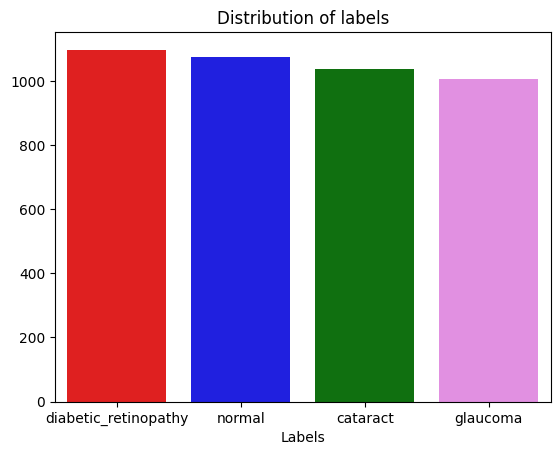

In [ ]:
labels=df['Labels'].value_counts()
custom_palette = sns.color_palette(["red", "blue", "green", "violet"])
sns.barplot(x=labels.index,y=labels.values,palette=custom_palette)
plt.title('Distribution of labels')

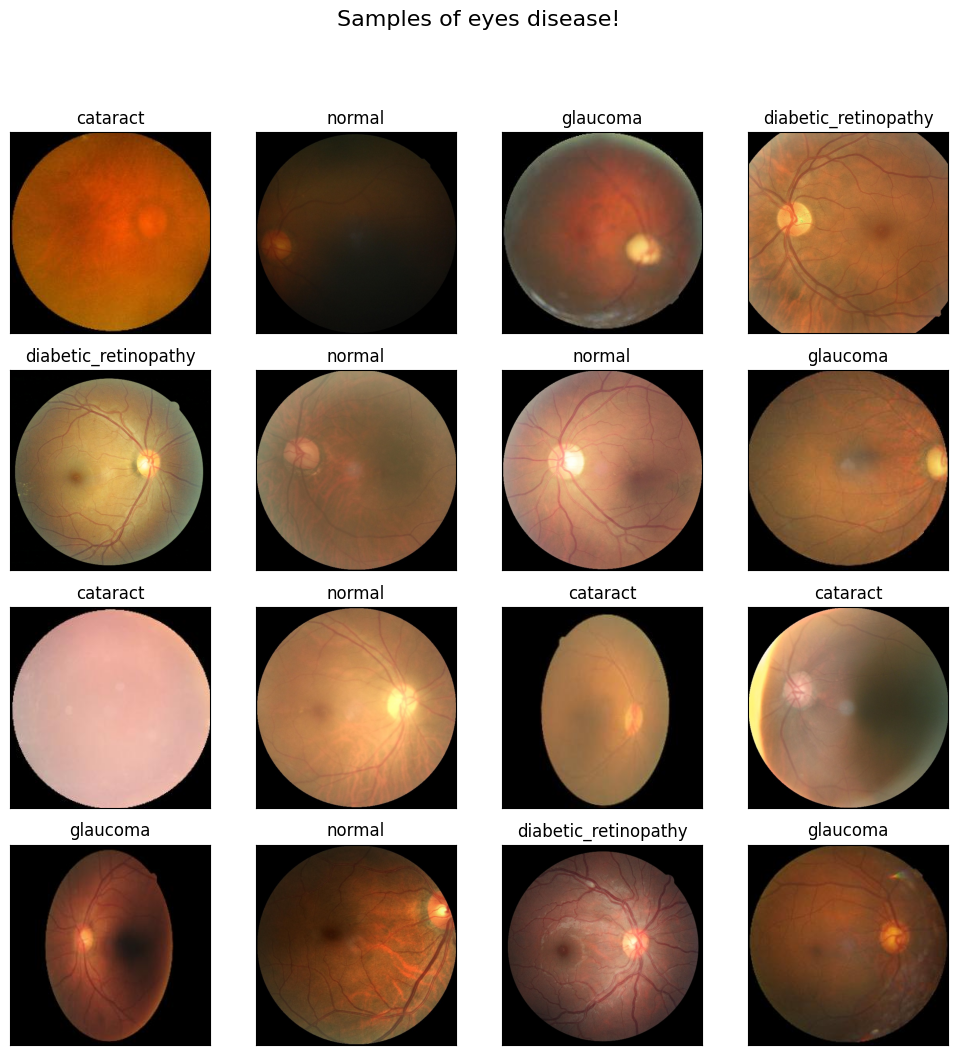

In [ ]:
def show_image_sample(df):
    random_data = df.sample(n=16)
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})
    plt.suptitle('Samples of eyes disease!', y=1.05, fontsize=16)

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(random_data.iloc[i].Filepath))
        ax.set_title(random_data.iloc[i].Labels)
    plt.tight_layout()
    plt.show()

show_image_sample(df)

In [ ]:
train_df,dummy_df=train_test_split(df,train_size=0.8,random_state=42,stratify=df['Labels'])

In [ ]:
val_df,test_df=train_test_split(dummy_df,train_size=0.5,random_state=42,stratify=dummy_df['Labels'])

In [ ]:
train_df.shape,test_df.shape,val_df.shape

((3373, 2), (422, 2), (422, 2))

In [ ]:
train_df

,Filepath,Labels
1573,/content/dataset/normal/2685_left.jpg,normal
2381,/content/dataset/glaucoma/_105_9159338.jpg,glaucoma
1504,/content/dataset/normal/2826_right.jpg,normal
567,/content/dataset/cataract/2198_right.jpg,cataract
1296,/content/dataset/normal/3324_right.jpg,normal
...,...,...
260,/content/dataset/cataract/_97_761368.jpg,cataract
3378,/content/dataset/diabetic_retinopathy/11130_ri...,diabetic_retinopathy
500,/content/dataset/cataract/_154_1054490.jpg,cataract
846,/content/dataset/cataract/_249_4807123.jpg,cataract


In [ ]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    vertical_flip=True,
)
test_gen = ImageDataGenerator(
    rescale=1./255

)
val_gen = ImageDataGenerator(
    rescale=1./255,
)

In [ ]:
train= train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Labels',
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True)
test = test_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Labels',
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
   )
val = val_gen.flow_from_dataframe(
    val_df,
    x_col='Filepath',
    y_col='Labels',
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
    )

Found 3373 validated image filenames belonging to 4 classes.
Found 422 validated image filenames belonging to 4 classes.
Found 422 validated image filenames belonging to 4 classes.


In [ ]:
basemodel=tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE,IMG_SIZE,3),
    pooling='max',
)

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
model=tf.keras.models.Sequential([
    basemodel,
    layers. Dense(256,activation='relu'),
    layers.Dropout(rate= 0.45, seed= 123),
    layers.BatchNormalization(),

    layers.Dense(N_CLASSES,activation='softmax')


])

In [ ]:
model.build(input_shape=INPUT_SHAPE)

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_resnet_v2 (Functional)     │ (32, 1536)                  │      54,336,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 256)                   │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_203              │ (32, 256)                   │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 4)                     │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,732,260 (208.79 MB)

 Trainable params: 54,671,204 (208.55 MB)

 Non-trainable params: 61,056 (238.50 KB)

In [ ]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
checkpoint = callbacks.ModelCheckpoint('eyesmodel.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=8, mode='min')

# Train the model
history = model.fit(
    train,
    epochs=EPOCHS,
    verbose=1,
    batch_size=BATCH_SIZE,
    validation_data=val,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6724 - loss: 0.8770
Epoch 1: val_loss improved from inf to 6.26914, saving model to eyesmodel.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 349s 2s/step - accuracy: 0.6733 - loss: 0.8749 - val_accuracy: 0.6043 - val_loss: 6.2691
Epoch 2/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.8657 - loss: 0.3703
Epoch 2: val_loss improved from 6.26914 to 0.50853, saving model to eyesmodel.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 148s 839ms/step - accuracy: 0.8659 - loss: 0.3700 - val_accuracy: 0.8341 - val_loss: 0.5085
Epoch 3/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.9039 - loss: 0.2827
Epoch 3: val_loss did not improve from 0.50853
106/106 ━━━━━━━━━━━━━━━━━━━━ 58s 528ms/step - accuracy: 0.9039 - loss: 0.2826 - val_accuracy: 0.8483 - val_loss: 0.5620
Epoch 4/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.9131 - loss: 0.2667
Epoch 4: val_loss improved from 0.50853 to 0.25531, saving model to eyesmodel.keras
106/106 

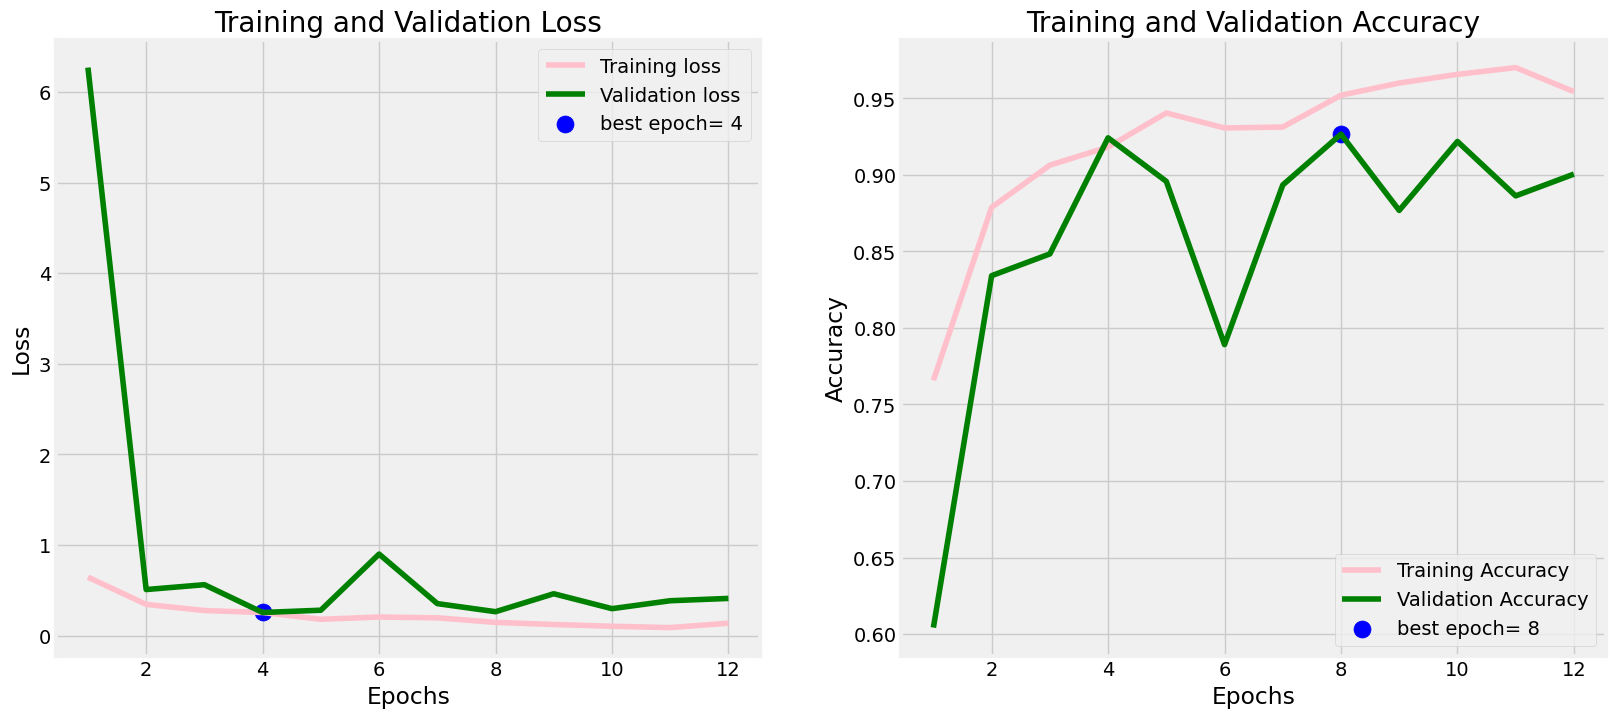

In [ ]:
#Show Model Performance
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'pink', label= 'Training loss')
plt.plot(Epochs, val_loss, 'green', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'pink', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'green', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
#Evaluate The Model
train_score = model.evaluate(train, verbose= 1)
valid_score = model.evaluate(val, verbose= 1)
test_score = model.evaluate(test, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

106/106 ━━━━━━━━━━━━━━━━━━━━ 30s 281ms/step - accuracy: 0.9531 - loss: 0.2086
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - accuracy: 0.9064 - loss: 0.3467


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step - accuracy: 0.9103 - loss: 0.3441
Train Loss:  0.20744673907756805
Train Accuracy:  0.9531574249267578
--------------------
Validation Loss:  0.4107201397418976
Validation Accuracy:  0.900473952293396
--------------------
Test Loss:  0.3085474967956543
Test Accuracy:  0.928909957408905


In [ ]:
y_test=test.classes
y_pred=model.predict(test)
y_pred=np.argmax(y_pred,axis=1)
print(classification_report(y_test,y_pred))

14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 964ms/step
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       104
           1       0.95      1.00      0.97       110
           2       0.92      0.88      0.90       101
           3       0.87      0.88      0.87       107

    accuracy                           0.93       422
   macro avg       0.93      0.93      0.93       422
weighted avg       0.93      0.93      0.93       422



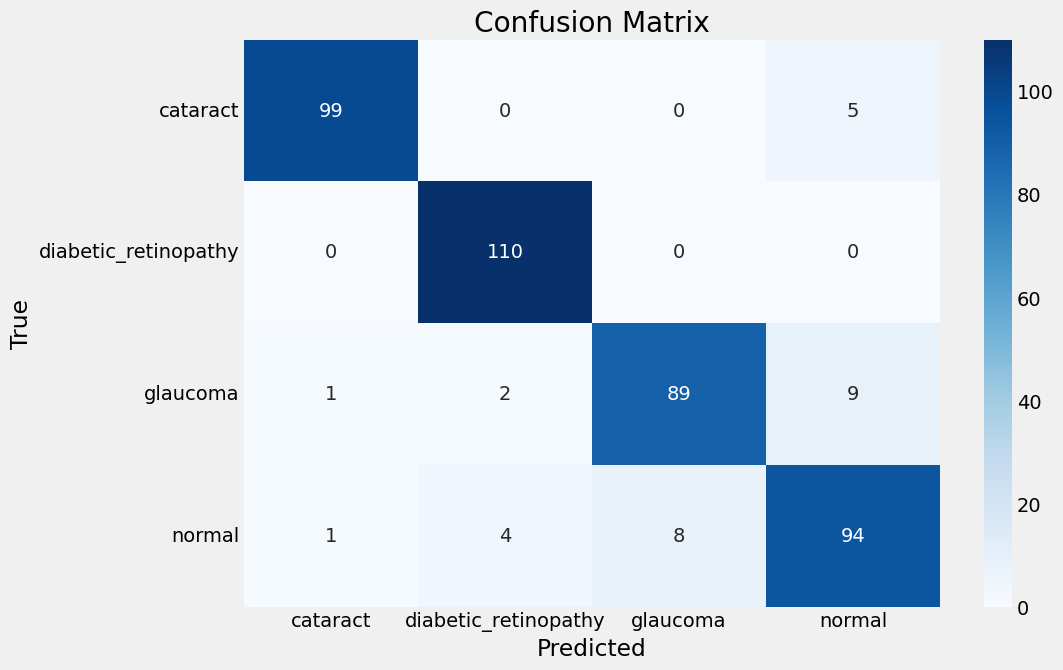

In [ ]:
def display_conf_matrix():
    cm = confusion_matrix(y_test, y_pred)

    # Convert class indices to class names
    class_names = list(test.class_indices.keys())

    # Create a heatmap using seaborn
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    # Set the labels and title
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

    # Display the plot
    plt.show()
display_conf_matrix()